##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Release Notes notebook (0.11.0)

The intent of this notebook is to help TFP 0.11.0 "come to life" via some small snippets - little demos of things you can achieve with TFP.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/TFP_Release_Notebook_0_11_0"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_11_0.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_11_0.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_11_0.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
#@title Installs & imports { vertical-output: true }
!pip3 install -U -q tensorflow==2.3.0 tensorflow_probability==0.11.0

import tensorflow as tf
import tensorflow_probability as tfp
assert '0.11' in tfp.__version__, tfp.__version__
assert '2.3' in tf.__version__, tf.__version__
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import IPython
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TFP can run on JAX
_Note, this has moved up to `tfp.substrates` in nightly builds._

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


jit vmap sample: [ 2.17746     2.6618252   3.427014   -0.80979496  5.87146     4.2002716
  1.2994273   1.2281269   3.5244293   4.1996603 ]


/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


vmap grad: (DeviceArray([ 0.04436499,  0.1654563 ,  0.35675353, -0.70244873,
              0.96786499,  0.5500679 , -0.17514318, -0.19296828,
              0.38110733,  0.54991508], dtype=float64), DeviceArray([-0.4960635 , -0.44524843, -0.24545383,  0.48686844,
              1.37352526,  0.10514939, -0.43864973, -0.42552648,
             -0.20951441,  0.10481316], dtype=float64), DeviceArray([-0.04436499, -0.1654563 , -0.35675353,  0.7024487 ,
             -0.967865  , -0.5500679 ,  0.17514318,  0.19296828,
             -0.38110733, -0.5499151 ], dtype=float32))
hmm: (DeviceArray([-0.30260671, -0.38072154,  0.57980393, -0.30949971,
              1.22571819, -1.72733693, -1.13891736, -0.05021395,
              0.33300565, -0.31721795], dtype=float64), DeviceArray(-12.69673571, dtype=float64))
nuts:


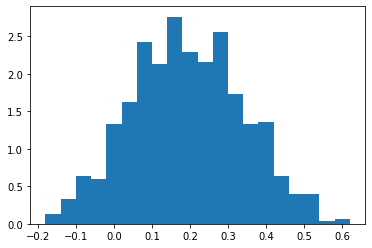

In [2]:
import jax
from jax import config
config.update('jax_enable_x64', True)

def demo_jax():
  from tensorflow_probability.python.experimental.substrates import jax as tfp
  tfd = tfp.distributions
  tfb = tfp.bijectors

  @jax.jit
  def vmap_sample(seeds):
    d = tfb.Shift(2.)(tfb.Scale(2.)(tfd.Normal(0, 1)))
    return jax.vmap(lambda seed: d.sample(seed=seed))(seeds)

  def vmap_grad(seeds, sh, sc):
    d = lambda sh, sc: tfb.Shift(sh)(tfb.Scale(sc)(tfd.Normal(0, 1)))
    return jax.vmap(
        jax.grad(lambda sh, sc, samp: d(sh, sc).log_prob(samp), 
                 argnums=(0,1,2)),
        in_axes=(None, None, 0))(sh, sc, vmap_sample(seeds))

  seed = jax.random.PRNGKey(123)
  seeds = jax.random.split(seed, 10)
  print('jit vmap sample:', vmap_sample(seeds))
  print('vmap grad:', vmap_grad(seeds, 2., 2.))

  @jax.jit
  def hmm_sample(seed):
    init, transition, obsv, sample = jax.random.split(seed, num=4)
    d = tfd.HiddenMarkovModel(
        initial_distribution=tfd.Categorical(logits=jax.random.uniform(init, [3]) + .1),
        transition_distribution=tfd.Categorical(logits=jax.random.uniform(transition, [3, 3]) + .1),
        observation_distribution=tfd.Normal(loc=jax.random.normal(obsv, [3]), scale=1.),
        num_steps=10)
    samps = d.sample(seed=sample)
    return samps, d.log_prob(samps)
  print('hmm:', hmm_sample(jax.random.PRNGKey(123)))

  @jax.jit
  def nuts(seed):
    return tfp.mcmc.sample_chain(
        num_results=10,
        num_burnin_steps=50,
        current_state=np.zeros([75]),
        kernel=tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=lambda x: -(x - .2)**2 / .05,
            step_size=.1),
        trace_fn=None,
        seed=seed)
  print('nuts:')
  plt.hist(nuts(seed=jax.random.PRNGKey(7)).reshape(-1), bins=20, density=True)

demo_jax()

## Inference with Sequential Monte Carlo (experimental)

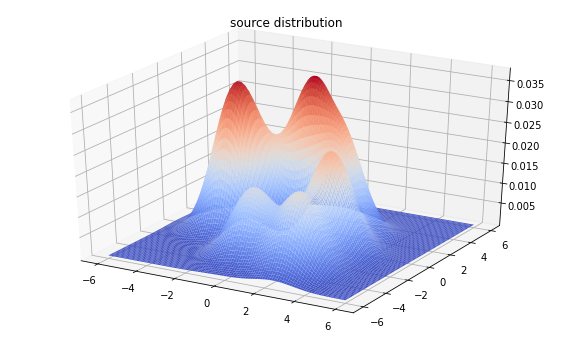

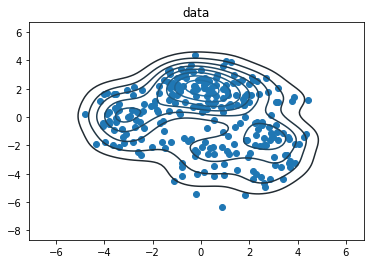

In [4]:
nmodes = 7
loc_prior = tfd.MultivariateNormalDiag(loc=[0, 0], scale_diag=[2, 2])
mode_locs = loc_prior.sample(nmodes, seed=(0, 1))
logits_prior = tfd.Uniform()
mode_logits = logits_prior.sample(nmodes, seed=(0, 2))

make_mvn = lambda locs: tfd.MultivariateNormalDiag(
    loc=locs, scale_diag=tf.ones_like(locs))
make_mixture = lambda locs, logits: tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=logits),
    components_distribution=make_mvn(locs))

true_dist = make_mixture(mode_locs, mode_logits)

from mpl_toolkits import mplot3d
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)

X, Y = np.asarray(np.meshgrid(x, y), dtype=np.float32)

Z = true_dist.prob(tf.stack([X, Y], axis=-1))
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
plt.title('source distribution')
plt.show()

data_size = 256
samps = true_dist.sample(data_size, seed=(0, 3))
sns.kdeplot(*samps.numpy().T)
plt.scatter(*samps.numpy().T)
plt.title('data')
plt.show()

In [5]:
nparticles = 2048
seed = ()
(n_stage, final_state, final_kernel_results
  ) = tfp.experimental.mcmc.sample_sequential_monte_carlo(
      prior_log_prob_fn=lambda locs, logits: (
          tf.reduce_sum(loc_prior.log_prob(locs)) +
          tf.reduce_sum(logits_prior.log_prob(logits))),
      likelihood_log_prob_fn=lambda locs, logits: (
          tfd.Sample(make_mixture(locs, logits), data_size).log_prob(samps)),
      current_state=(loc_prior.sample([nparticles, nmodes + 2]), 
                     logits_prior.sample([nparticles, nmodes + 2])),
)

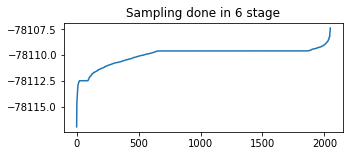

In [6]:
# Identify any issues with particle weight collapse.
plt.figure(figsize=(5,2))
plt.plot(tf.sort(final_kernel_results.particle_info.tempered_log_prob));
plt.title(f'Sampling done in {n_stage} stage');

tfp.distributions.MixtureSameFamily("ensembled_posterior", batch_shape=[], event_shape=[2], dtype=float32)


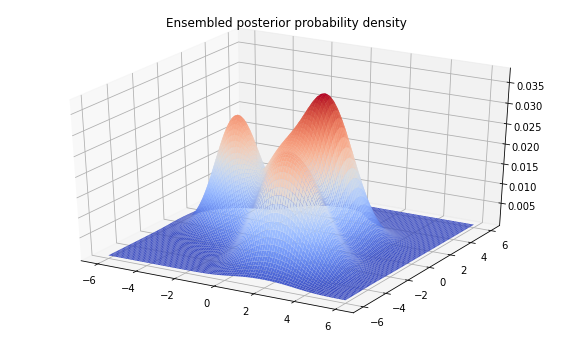

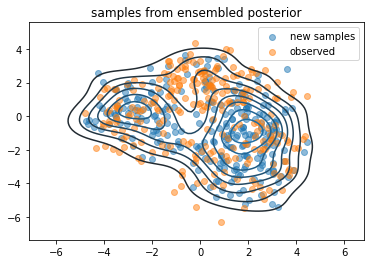

In [7]:
sampled_distributions = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        logits=final_kernel_results.particle_info.tempered_log_prob),
    components_distribution=make_mixture(*final_state),
    name='ensembled_posterior')
print(sampled_distributions)
Z = sampled_distributions.prob(tf.stack([X, Y], axis=-1))
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
plt.title('Ensembled posterior probability density')
plt.show()

samps2 = sampled_distributions.sample(256, seed=(0, 4))
sns.kdeplot(*samps2.numpy().T)
# sns.kdeplot(*samps.numpy().T)
plt.scatter(*samps2.numpy().T, alpha=.5, label='new samples')
plt.scatter(*samps.numpy().T, alpha=.5, label='observed')
plt.legend()
plt.title('samples from ensembled posterior')
plt.show()

## Spherical distributions: SphericalUniform (new), PowerSpherical (new), VonMisesFisher

In [8]:
#@title `plot_spherical`
def plot_spherical(dist, nsamples):
  samples = dist.sample([nsamples], seed=123)
  probs = dist.prob(samples)
  samples = samples.numpy()
  probs = probs.numpy()
  # Show the dynamic range of the sample probabilities by re-scaling with min/max.
  minp, maxp = probs.min(), probs.max()
  ranged = np.float64(
      (probs - minp) / np.where(maxp - minp > 0, (maxp - minp), minp)) * .8 + .2

  data = list(map(list, samples))
  colors = map(plt.get_cmap('plasma'), ranged)
  colors = list(map(list, colors))

  js = """
    var scene = new THREE.Scene();
    var camera = new THREE.PerspectiveCamera( 75, 1.0, 0.1, 1000 );

    var renderer = new THREE.WebGLRenderer();
    renderer.setSize( 500, 500 );
    document.body.appendChild( renderer.domElement );

    var sphere_geom = new THREE.SphereBufferGeometry(1, 200, 200);
    var sphere_mat = new THREE.MeshBasicMaterial(
        {'opacity': 0.25, 'color': 0xFFFFFF, 'transparent': true});
    var sphere = new THREE.Mesh(sphere_geom, sphere_mat);
    sphere.position.set(0, 0, 0);
    scene.add(sphere);

    var points_data = %s;
    var points = [];
    for (var i = 0; i < points_data.length; i++) {
      points.push(new THREE.Vector3(
          points_data[i][0], points_data[i][1], points_data[i][2]));
    }

    var points_geom = new THREE.Geometry();
    points_geom.vertices = points;

    var colors_data = %s;
    var colors = [];
    for (var i = 0; i < colors_data.length; i++) {
      colors.push(new THREE.Color(
          colors_data[i][0], colors_data[i][1], colors_data[i][2]));
    }
    points_geom.colors = colors;
    var points_mat = new THREE.PointsMaterial({'size': 0.015});
    points_mat.vertexColors = THREE.VertexColors;
    var points = new THREE.Points(points_geom, points_mat);
    scene.add(points);

    camera.position.x = 0;
    camera.position.y = -2;
    camera.position.z = 2;
    camera.lookAt(new THREE.Vector3(0, 0, 0));

    controls = new THREE.TrackballControls(camera, renderer.domElement);
    controls.rotateSpeed = 1.0;
    controls.zoomSpeed = 1.2;
    controls.panSpeed = 0.8;
    controls.noZoom = false;
    controls.noPan = false;
    controls.staticMoving = false;
    controls.dynamicDampingFactor = 0.15;

    /* 
    Keep the camera pointing the same direction it was before.  However, 
    this does not generally have the same actual target as the original camera
    lookAt, only the same direction.  So when the user rotates the view it 
    might not have the expected origin of rotation. 
    */
    look_at = new THREE.Vector3(0, 0, -1);
    look_at.applyQuaternion(camera.quaternion).add(camera.position)
    controls.target = look_at;

    var LookAt = function(x, y, z) {
      camera.lookAt(new THREE.Vector3(x, y, z));
      controls.target.set(x, y, z);
    };
    LookAt(0, 0, 0);

    var animate = function () {
      requestAnimationFrame( animate );
      controls.update();
      renderer.render( scene, camera );
    };

    animate();
  """ % (repr(data), repr(colors))

  IPython.display.display_html("""
  <script type='text/javascript' src='https://ajax.googleapis.com/ajax/libs/threejs/r84/three.min.js'></script>
  <script type='text/javascript' src='https://cdn.rawgit.com/mrdoob/three.js/a1daef37/examples/js/controls/TrackballControls.js'></script>
  <script type='text/javascript'>
  %s
  </script>
  <b>Spin me!</b>
  """ % js, raw=True)

In [9]:
#@title Visualizing `tfd.SphericalUniform` in 3 dimensions { run: "auto", vertical-output: true }
nsamples = 2000  #@param {type:"integer"}
d = tfd.SphericalUniform(dimension=3)
plot_spherical(d, nsamples)

Spin me!

In [10]:
#@title Visualizing `tfd.PowerSpherical` in 3 dimensions { run: "auto", vertical-output: true }
concentration = 5.0  #@param {type:"number"}
nsamples = 2000  #@param {type:"integer"}
d = tfd.PowerSpherical(
    mean_direction=tf.nn.l2_normalize(np.float64([1, 1, 1]), axis=-1), 
    concentration=np.float64(concentration))
plot_spherical(d, nsamples)

In [11]:
#@title Visualizing `tfd.VonMisesFisher` in 3 dimensions { run: "auto", vertical-output: true }
concentration = 5.0  #@param {type:"number"}
nsamples = 2000  #@param {type:"integer"}
vmf = tfp.distributions.VonMisesFisher(
    mean_direction=tf.nn.l2_normalize(np.float64([1, 1, 1]), axis=-1), 
    concentration=np.float64(concentration))
plot_spherical(vmf, nsamples)

## New Bijectors

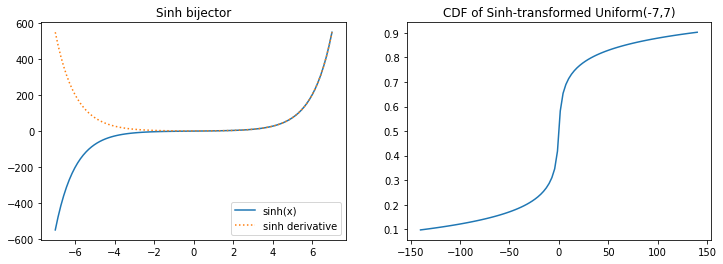

In [40]:
#@title `tfb.Sinh`
plt.figure(figsize=(12, 4))
plt.subplot(121)
xs = np.linspace(-7, 7, 100)
plt.plot(xs, tfb.Sinh()(xs), label='sinh(x)')
plt.plot(xs, tf.math.exp(tfb.Sinh().forward_log_det_jacobian(xs, event_ndims=0)), ':', label='sinh derivative');
plt.legend()
plt.title('Sinh bijector')
plt.subplot(122)
xs *= 20
plt.plot(xs, tfb.Sinh()(tfd.Uniform(-7, 7)).cdf(xs))
plt.title('CDF of Sinh-transformed Uniform(-7,7)');

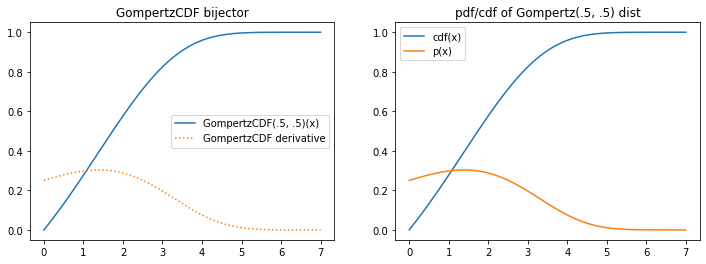

In [37]:
#@title `tfb.GompertzCDF`
plt.figure(figsize=(12, 4))
plt.subplot(121)
xs = np.linspace(0, 7, 100).astype(np.float32)
b = tfb.GompertzCDF(.5, .5)
plt.plot(xs, b(xs), label='GompertzCDF(.5, .5)(x)')
plt.plot(xs, tf.math.exp(b.forward_log_det_jacobian(xs, event_ndims=0)), ':', label='GompertzCDF derivative');
plt.legend()
plt.title('GompertzCDF bijector')
plt.subplot(122)
d = tfb.Invert(b)(tfd.Uniform(0, 1))
plt.plot(xs, d.cdf(xs), label='cdf(x)')
plt.plot(xs, d.prob(xs), label='p(x)')
plt.legend()
plt.title('pdf/cdf of Gompertz(.5, .5) dist');

## New distributions

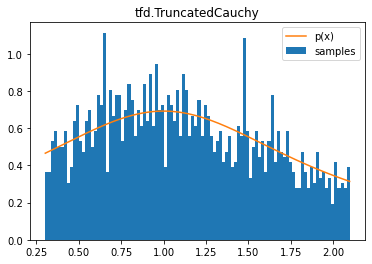

In [13]:
#@title `tfd.TruncatedCauchy`
d = tfd.TruncatedCauchy(1, 1, .3, 2.1)
samples = tf.sort(d.sample(2000, seed=(0, 1)))
plt.hist(samples, bins=100, density=True, label='samples')
plt.plot(samples, d.prob(samples), label='p(x)')
plt.title('tfd.TruncatedCauchy')
plt.legend();

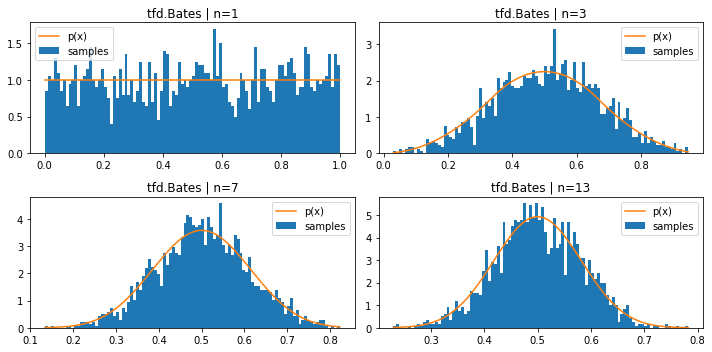

In [14]:
#@title `tfd.Bates` (mean of `n` uniform samples)
plt.figure(figsize=(10, 5))
for i, n in enumerate((1, 3, 7, 13)):
  plt.subplot(221+i)
  d = tfd.Bates(total_count=n)
  samples = tf.sort(d.sample(2000, seed=(1, 2)))
  plt.hist(samples, bins=100, density=True, label='samples')
  plt.plot(samples, d.prob(samples), label='p(x)')
  plt.title(f'tfd.Bates | n={n}')
  plt.legend()
  plt.tight_layout()

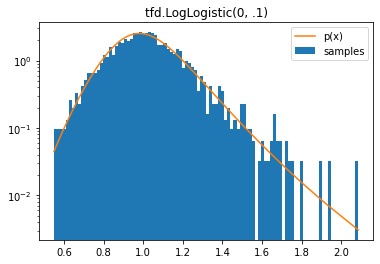

In [15]:
#@title `tfd.LogLogistic`
d = tfd.LogLogistic(0, .1)
samples = tf.sort(d.sample(2000, seed=(2, 3)))
plt.hist(samples, bins=100, density=True, log=True, label='samples')
plt.plot(samples, d.prob(samples), label='p(x)')
plt.legend()
plt.title('tfd.LogLogistic(0, .1)');

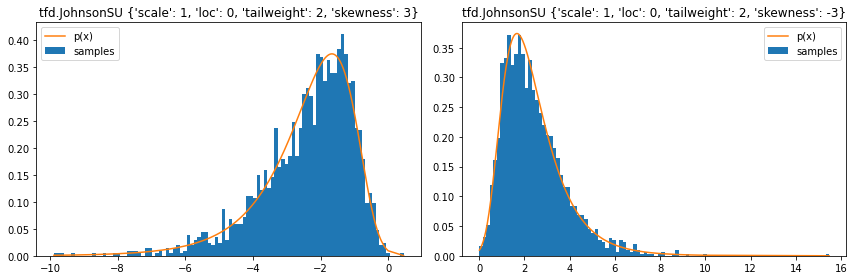

In [16]:
#@title `tfd.JohnsonSU`
stats = ('loc', 'scale', 'tailweight', 'skewness')
plt.figure(figsize=(12, 4))
for i, d in enumerate([
    tfd.JohnsonSU(skewness=3, tailweight=2, loc=0, scale=1),
    tfd.JohnsonSU(skewness=-3, tailweight=2, loc=0, scale=1)]):
  plt.subplot(121+i)
  samples = tf.sort(d.sample(2000, seed=(2, 4)))
  plt.hist(samples, bins=100, density=True, label='samples')
  plt.plot(samples, d.prob(samples), label='p(x)')
  plt.legend()
  plt.title(f'tfd.JohnsonSU { {k: v for (k, v) in d.parameters.items() if k in stats} }')
  plt.tight_layout();

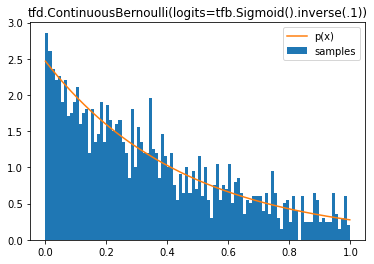

In [17]:
#@title `tfd.ContinuousBernoulli`
d = tfd.ContinuousBernoulli(logits=tfb.Sigmoid().inverse(.1))
samples = tf.sort(d.sample(2000, seed=(2, 3)))
plt.hist(samples, bins=100, density=True, label='samples')
plt.plot(samples, d.prob(samples), label='p(x)')
plt.legend()
plt.title('tfd.ContinuousBernoulli(logits=tfb.Sigmoid().inverse(.1))');

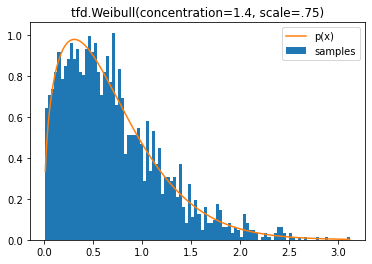

In [18]:
#@title `tfd.Weibull`
d = tfd.Weibull(concentration=1.4, scale=.75)
samples = tf.sort(d.sample(2000, seed=(2, 3)))
plt.hist(samples, bins=100, density=True, label='samples')
plt.plot(samples, d.prob(samples), label='p(x)')
plt.legend()
plt.title('tfd.Weibull(concentration=1.4, scale=.75)');

## Auto-vectorized sampling with `JointDistribution*AutoBatched`
If you've ever struggled getting batch dimensions to line up correctly in your joint distributions, this is for you.

### Ever written code like this?

In [19]:
data = tf.random.stateless_normal([7], seed=(1,2))

@tfd.JointDistributionCoroutine
def model():
  root = tfd.JointDistributionCoroutine.Root
  scale = yield root(tfd.Gamma(1, 1, name='scale'))
  yield tfd.Normal(tf.zeros_like(data), scale)

model.sample()

(<tf.Tensor: shape=(), dtype=float32, numpy=4.1253977>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-2.814606  ,  0.81064916, -1.1025742 , -1.8684998 , -2.9547117 ,
        -0.19623983, -0.15587877], dtype=float32)>)

### Then hit exceptions drawing non-scalar samples?

In [28]:
print(model.sample(1), '\n  (^^ silent badness: the second value lacks a leading (1,) shape)')
print('sampling (3,) will break:')
import traceback
try:
  model.sample(3)
except ValueError as e:
  traceback.print_exc()

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.15810375], dtype=float32)>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-0.03214252,  0.15187298, -0.08423525, -0.03807954,  0.25466064,
       -0.14433853,  0.2543037 ], dtype=float32)>) 
  (^^ silent badness: the second value lacks a leading (1,) shape)
sampling (3,) will break:


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/normal.py", line 243, in _parameter_control_dependencies
    self._batch_shape()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/normal.py", line 176, in _batch_shape
    return tf.broadcast_static_shape(self.loc.shape, self.scale.shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 554, in broadcast_static_shape
    return common_shapes.broadcast_shape(shape_x, shape_y)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/common_shapes.py", line 107, in broadcast_shape
    % (shape_x, shape_y))
ValueError: Incompatible shapes for broadcasting: (7,) and (3,)

During handling of the above exception, another exception oc

### Now, you can use `tfd.JointDistributionCoroutineAutoBatched` & friends
You write a "scalar" sampling routine, then draw arbitrary sample shapes.

In [21]:
@tfd.JointDistributionCoroutineAutoBatched
def model_auto():
  scale = yield tfd.Gamma(1, 1, name='scale')
  yield tfd.Normal(tf.zeros_like(data), scale)

print(model_auto.sample(), '\n  (scalar sample)')
print(model_auto.sample(1), '\n  ((1,) sample)')
print(model_auto.sample(3), '\n  ((3,) sample)')

(<tf.Tensor: shape=(), dtype=float32, numpy=1.5234255>, <tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-0.7177643 , -2.7825186 , -1.1250918 ,  0.57446253, -1.0755515 ,
        2.6673915 , -1.776087  ], dtype=float32)>) 
  (scalar sample)


(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.48698178], dtype=float32)>, <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 0.44244727, -0.548889  ,  0.29392514, -0.5249126 , -0.6618264 ,
         0.06925056, -0.32040703]], dtype=float32)>) 
  ((1,) sample)


(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5501703, 1.9277483, 2.7804365], dtype=float32)>, <tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[-1.1568309 ,  0.02062727,  0.04918252, -0.08978909,  0.6446161 ,
        -0.16725235, -0.27897784],
       [-2.9246418 , -1.2733852 ,  1.0071639 , -0.4655921 , -4.1095695 ,
         0.1298227 ,  3.0307395 ],
       [-2.7411313 ,  1.6211014 , -1.600051  , -1.4009917 ,  4.081262  ,
         1.7097493 ,  2.8525631 ]], dtype=float32)>) 
  ((3,) sample)


## Reproducible sampling, even in eager

In [22]:
tf.random.set_seed(123)
print('Stateful sampling:\t\t', 
      tfd.Normal(0, 1).sample(seed=234),
      'then', 
      tfd.Normal(0, 1).sample(seed=234))  

# Why are they different?
# TF samplers are stateful by default (TF maintains is a global PRNG).
# How to get reproducible results in eager mode?
tf.random.set_seed(123)
print('Stateful sampling (set_seed):\t',
      tfd.Normal(0, 1).sample(seed=234))

# And what about tf.function?
@tf.function
def sample_normal():
  return tfd.Normal(0, 1).sample(seed=234)
tf.random.set_seed(123)
print('tf.function:\t\t', sample_normal(), 'vs', sample_normal())
tf.random.set_seed(123)
print('tf.function (set_seed):\t', sample_normal())

# Using a Tensor seed (or a tuple, which TFP will convert to a tensor) induces
# TFP behavior analagous to the tf.random.stateless_* ops. This sampling 
# is fully deterministic.
print('Stateless sampling (tuple):\t\t',
      tfd.Normal(0, 1).sample(seed=(1, 23)))
print('Stateless sampling (tensor):\t\t',
      tfd.Normal(0, 1).sample(seed=tf.constant([1, 23], dtype=tf.int32)))
# Even in tf.function
@tf.function
def sample_normal():
  return tfd.Normal(0, 1).sample(seed=(1, 23))
print('Stateless sampling (tf.function):\t', sample_normal())

# And independent of global seeds.
tf.random.set_seed(321)
print('Stateless sampling (ignores set_seed):\t', sample_normal())

Stateful sampling:		 tf.Tensor(0.54054874, shape=(), dtype=float32) then tf.Tensor(-1.5518123, shape=(), dtype=float32)
Stateful sampling (set_seed):	 tf.Tensor(0.54054874, shape=(), dtype=float32)
tf.function:		 tf.Tensor(0.54054874, shape=(), dtype=float32) vs tf.Tensor(-1.5518123, shape=(), dtype=float32)
tf.function (set_seed):	 tf.Tensor(0.54054874, shape=(), dtype=float32)
Stateless sampling (tuple):		 tf.Tensor(-0.36107817, shape=(), dtype=float32)
Stateless sampling (tensor):		 tf.Tensor(-0.36107817, shape=(), dtype=float32)
Stateless sampling (tf.function):	 tf.Tensor(-0.36107817, shape=(), dtype=float32)
Stateless sampling (ignores set_seed):	 tf.Tensor(-0.36107817, shape=(), dtype=float32)


### Similarly, `tfp.mcmc.sample_chain` now accepts stateless seeds
This is passed to underlying kernels, which must be updated to accept a `seed` argument to `one_step` if they make random proposals. (Built-in kernels are already updated.)

In [23]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(lambda x: -(x - .2)**2,
                                        step_size=1.,
                                        num_leapfrog_steps=2)
print_n_lines = lambda x, n: print('\n'.join(repr(x).split('\n')[:n] + ['...']))
print_n_lines(
    tfp.mcmc.sample_chain(
        num_results=5,
        num_burnin_steps=100,
        current_state=tf.zeros([3]),
        kernel=kernel,
        trace_fn=lambda state, kr: kr,
        seed=(1, 2)),
    17)
print('And again (reproducibly)...')
print_n_lines(
    tfp.mcmc.sample_chain(
        num_results=5,
        num_burnin_steps=100,
        current_state=tf.zeros([3]),
        kernel=kernel,
        trace_fn=lambda state, kr: kr,
        seed=(1, 2)),
    17)

StatesAndTrace(
  all_states=<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
    array([[ 4.0000078e-01,  3.9999962e-01,  3.9999855e-01],
           [-8.3446503e-07,  3.5762787e-07,  1.5497208e-06],
           [ 4.0000081e-01,  3.9999965e-01,  3.9999846e-01],
           [-8.3446503e-07,  4.7683716e-07,  1.5497208e-06],
           [ 4.0000087e-01,  3.9999962e-01,  3.9999843e-01]], dtype=float32)>,
  trace=MetropolisHastingsKernelResults(
      accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
          log_acceptance_correction=<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
            array([[ 0.0000000e+00, -2.9802322e-08,  0.0000000e+00],
                   [ 5.9604645e-08,  1.1175871e-08,  1.1920929e-07],
                   [-2.9802322e-08, -2.7939677e-09,  2.7939677e-09],
                   [ 0.0000000e+00,  0.0000000e+00, -5.9604645e-08],
                   [ 1.4901161e-08, -1.7881393e-07,  0.0000000e+00]], dtype=float32)>,
          target_log_prob=<tf.Tensor: sha

## Pretty printing MCMC kernel results

In [3]:
tfp.mcmc.RandomWalkMetropolis(tfd.Uniform(0, 10).log_prob).bootstrap_results(1.)

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedRandomWalkResults(
      log_acceptance_correction=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
      target_log_prob=<tf.Tensor: shape=(), dtype=float32, numpy=-2.3025851>,
      seed=[]
    ),
  is_accepted=<tf.Tensor: shape=(), dtype=bool, numpy=True>,
  log_accept_ratio=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  proposed_state=1.0,
  proposed_results=UncalibratedRandomWalkResults(
      log_acceptance_correction=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
      target_log_prob=<tf.Tensor: shape=(), dtype=float32, numpy=-2.3025851>,
      seed=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>
    ),
  extra=[],
  seed=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0], dtype=int32)>
)

## CompositeTensor (experimental)
Save on tracing a `tf.function`. Return distributions from a `tf.function`.

In [24]:
@tf.function
def get_mean(d):
  return d.mean()

print(get_mean(tfp.experimental.as_composite(tfd.BetaBinomial(100., 2., 7.))))

@tf.function
def returns_dist(logits):
  return tfp.experimental.as_composite(tfd.Binomial(10., logits=logits))

print(returns_dist(tf.constant(0.)),
      returns_dist(tf.constant(0.)).sample(seed=(2, 3)))

tf.Tensor(22.222221, shape=(), dtype=float32)
tfp.distributions.BinomialCT("Binomial", batch_shape=[], event_shape=[], dtype=float32) tf.Tensor(5.0, shape=(), dtype=float32)


## Did you know: Batch slicing distributions

In [25]:
def demo_batch_slice():
  d = tfd.Normal(
      loc=tf.random.stateless_normal([100, 20, 3], seed=(1,2)),
      scale=1.)
  print(d, '\n  (original dist)')
  print(d[0], '\n  (0th element of the first batch dimension)')
  print(d[::2, ..., 1], '\n  (every other element of first dim  x  middle element of final dim)\n')

  d = tfd.Dirichlet(
      concentration=tf.random.stateless_uniform([100, 20, 3, 7], seed=(1,2)))
  print(d, '\n  (original dist)')
  print(d[:, 0], '\n  (0th element of the second dimension)')
  print(d[::2, ..., 1], '\n  (every other element of first dim  x  middle element of final dim)')
demo_batch_slice()

tfp.distributions.Normal("Normal", batch_shape=[100, 20, 3], event_shape=[], dtype=float32) 
  (original dist)
tfp.distributions.Normal("Normal", batch_shape=[20, 3], event_shape=[], dtype=float32) 
  (0th element of the first batch dimension)
tfp.distributions.Normal("Normal", batch_shape=[50, 20], event_shape=[], dtype=float32) 
  (every other element of first dim  x  middle element of final dim)

tfp.distributions.Dirichlet("Dirichlet", batch_shape=[100, 20, 3], event_shape=[7], dtype=float32) 
  (original dist)
tfp.distributions.Dirichlet("Dirichlet", batch_shape=[100, 3], event_shape=[7], dtype=float32) 
  (0th element of the second dimension)
tfp.distributions.Dirichlet("Dirichlet", batch_shape=[50, 20], event_shape=[7], dtype=float32) 
  (every other element of first dim  x  middle element of final dim)


## Random novelties: Sampling a sigmoidal Cox (nonhomogenous Poisson) process
We can use the thinning procedure proposed in [Adams et al.](https://icml.cc/Conferences/2009/papers/255.pdf)

Note that a similar thinning approach is relevant to some approaches to nonreversible MCMC (e.g. zig-zag and bouncy particle samplers), where an upper bound on intensity can be used to sample nonhomogenous events.

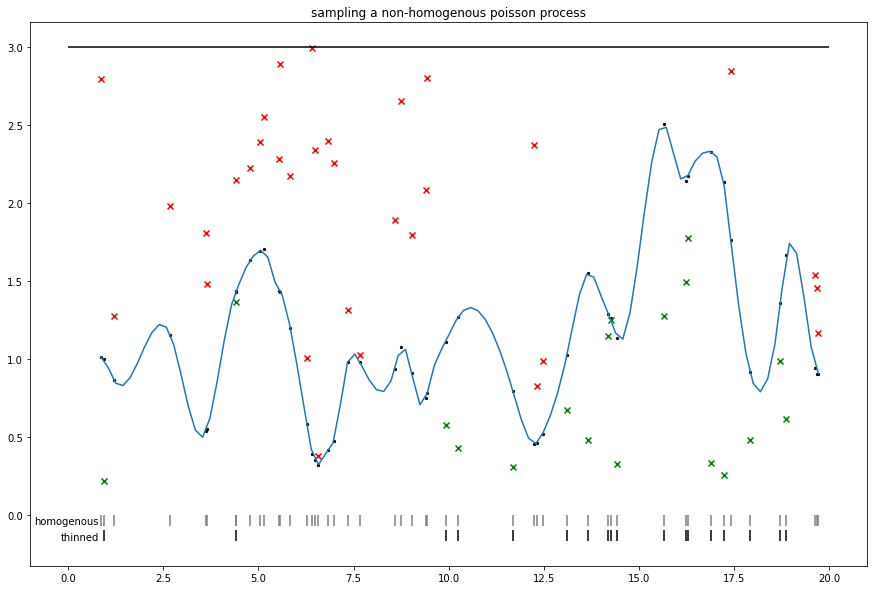

In [26]:
def sigmoidal_cox_process():
  V = 20.
  lam0 = 3.
  n_homog = tfd.Poisson(V * lam0).sample(seed=(0, 1))
  homog_locs = tf.sort(tfd.Uniform(0., V).sample(n_homog, seed=(0, 2)))
  homog_intensities = tfd.GaussianProcess(
      tfpk.MaternThreeHalves(), 
      index_points=homog_locs[:, tf.newaxis]).sample(seed=(0, 3))

  plt.figure(figsize=(15,10))
  plt.title('sampling a non-homogenous poisson process')
  plt.hlines(lam0, xmin=0., xmax=V)

  sigm_int = tf.math.sigmoid(homog_intensities) * lam0

  sp = scipy.interpolate.make_interp_spline(homog_locs, sigm_int)
  xs = np.linspace(homog_locs[0], homog_locs[-1], 100)
  ys = scipy.interpolate.splev(xs, sp)
  plt.plot(xs, ys)

  plt.scatter(homog_locs, sigm_int, s=5., c='black')

  unif = tfd.Uniform(0, lam0).sample(n_homog)
  plt.scatter(homog_locs, tf.where(unif < sigm_int, np.nan, unif), c='r', marker='x')
  plt.scatter(homog_locs, tf.where(unif > sigm_int, np.nan, unif), c='g', marker='x')

  plt.vlines(homog_locs, 0, -.07, colors='gray', )
  plt.text(.8, -.06, 'homogenous', dict(fontsize='medium'), horizontalalignment='right')

  nonhomog_locs = tf.gather(homog_locs, tf.where(unif < sigm_int))
  plt.vlines(nonhomog_locs, -.1, -.17, colors='black')
  plt.text(.8, -.16, 'thinned', dict(fontsize='medium'), horizontalalignment='right')
  plt.show()

sigmoidal_cox_process()

## Did you know: Batches of GPs
Gaussian Processes are distributions over functions. Here, we will parameterize by a kernel and a set of index points and showcase some of the batching behavior.

(TFP also supports a GP regression model, where the observations at observed index points determine the posterior distribution over functions on a set of index points, see [`tfd.GaussianProcessRegressionModel`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/GaussianProcessRegressionModel).)

We can set up a single GP over many examples of 2d feature
tfp.distributions.GaussianProcess("GaussianProcess", batch_shape=[], event_shape=[81], dtype=float32)


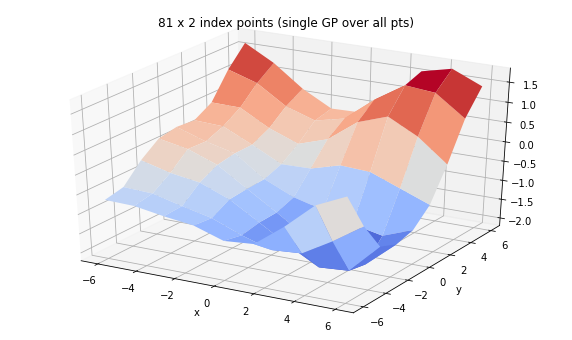

We can have a batch of independent GPs with their own sets of index points.
tfp.distributions.GaussianProcess("GaussianProcess", batch_shape=[9], event_shape=[9], dtype=float32)


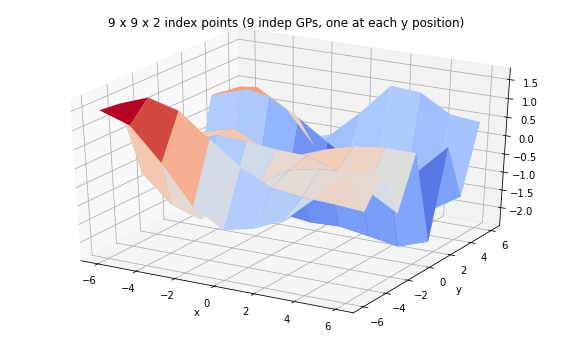

We can also have a corresponding batch of kernels.
tfp.math.psd_kernels.ExponentiatedQuadratic("ExponentiatedQuadratic", batch_shape=(9,), feature_ndims=1, dtype=float32)
tfp.distributions.GaussianProcess("GaussianProcess", batch_shape=[9], event_shape=[9], dtype=float32)


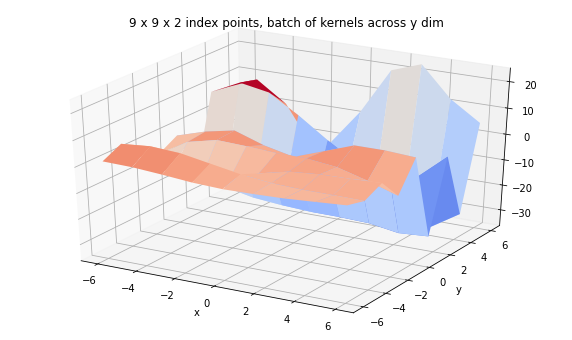

In [27]:
from mpl_toolkits import mplot3d
x = np.linspace(-6, 6, 9)
y = np.linspace(-6, 6, 9)

X, Y = np.asarray(np.meshgrid(x, y), dtype=np.float32)

print('We can set up a single GP over many examples of 2d feature')
gp = tfd.GaussianProcess(
    tfpk.ExponentiatedQuadratic(length_scale=3., feature_ndims=1),
    index_points=tf.reshape(tf.stack([X, Y], axis=-1), (-1, 2)),
    jitter=1e-3)
print(gp)
Z = tf.reshape(gp.sample(seed=(0,3)), X.shape)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none');
ax.set_xlabel('x');ax.set_ylabel('y');
ax.set_title('81 x 2 index points (single GP over all pts)')
plt.show()

print('We can have a batch of independent GPs with their own sets of index points.')
batch_gp = tfd.GaussianProcess(
    tfpk.ExponentiatedQuadratic(length_scale=3., feature_ndims=1),
    index_points=tf.stack([X, Y], axis=-1),
    jitter=1e-3)
print(batch_gp)
Z_batch = batch_gp.sample(seed=(5,7))
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(
    X, Y, Z_batch, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none');
ax.set_xlabel('x');ax.set_ylabel('y');
ax.set_title('9 x 9 x 2 index points (9 indep GPs, one at each y position)');
plt.show()

print('We can also have a corresponding batch of kernels.')
kernel = tfpk.ExponentiatedQuadratic(length_scale=3.,
                                     amplitude=tf.linspace(1., 20., 9),
                                     feature_ndims=1)
print(kernel)
batch_gp_kernel = tfd.GaussianProcess(
    kernel,
    index_points=tf.stack([X, Y], axis=-1),
    jitter=1e-3)
print(batch_gp_kernel)
Z_batch_kernel = batch_gp_kernel.sample(seed=(5,7))

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(
    X, Y, Z_batch_kernel, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none');
ax.set_xlabel('x');ax.set_ylabel('y');
ax.set_title('9 x 9 x 2 index points, batch of kernels across y dim');
